# Webtoon Segmentation Tutorial Using Mask R-CNN
To train only mask r-cnn, not detectron2 models, start here!

# "Mask R-CNN" ![Webtoon_segmentation](https://user-images.githubusercontent.com/56310078/117831341-6cd74400-b2af-11eb-8d23-d48a70a33a9a.png)

# Mask R-CNN Training and Inference
In this notebook we use Matterport's implementation of Mask R-CNN to train on our synthetic dataset, then use the trained weights to run inference on new images.

If you've never trained a neural network before, I wouldn't recommend starting here. Find a beginner deep learning tutorial/course and start there. I'd suggest the free course at https://course.fast.ai/. There are also lots of great free tutorials on YouTube, as well as paid courses on Udemy, Udacity, Coursera, etc.

## TensorFlow GPU
You definitely want TensorFlow GPU installed to run this notebook. Installation instructions are here:
https://www.tensorflow.org/install/gpu

This includes installing CUDA, which is no small task. If you want to do serious image recognition, you just have to push through the pain.

When I created this notebook, I updated my graphics driver to the latest, then installed the CUDA Toolkit and CUDNN. Tensorflow tends to not work if you have the wrong combo of CUDA/CUDNN, so I recommend checking out the [tested build configurations](https://www.tensorflow.org/install/source#tested_build_configurations). It took me a few frustrating hours of searching and trial and error to get a combination that worked.

## Keras
It seems that the latest versions of Keras aren't compatible with the Mask R-CNN code. Using version 2.2.4 worked for me and other students.

## My Combo that Worked
- **Python 3.6** (conda create -n tf-gpu python=3.6)
- **CUDA Toolkit 10.0** [https://developer.nvidia.com/cuda-zone](https://developer.nvidia.com/cuda-zone)
- **CUDNN 7.4.1** [https://developer.nvidia.com/cudnn](https://developer.nvidia.com/cudnn)
- **tensorflow-gpu 1.13.1** (pip install tensorflow-gpu==1.13.1)
- **keras 2.2.4** (pip install keras==2.2.4)

In [ ]:
%load_ext autoreload

In [ ]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
from pathlib import Path

# Import Matterport's "mrcnn" libraries
I'm using Matterport's Mask_RCNN git repo: https://github.com/matterport/Mask_RCNN

- Clone the Mask_RCNN repo to your computer.
- Update the code cell below to point to the root directory of the repo.
- Use pip to install everything from the requirements.txt file in that repo.

Read through their documentation and issues if you have any trouble getting started.

In [ ]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '../matterport_mask_rcnn/'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Using TensorFlow backend.


# Set up logging and pre-trained model paths
This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, update it here.

It will also download the pre-trained coco model.

In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Configuration
Define configurations for training on the box_dataset_synthetic dataset.
- Look through the code cell below and update any lines relevant to your custom dataset.
- You may want to change:
    - NAME (might want to be more specific)
    - NUM_CLASSES (always 1 + the number of object categories you have)
    - IMAGE_MIN_DIM (if you have larger training images)
    - IMAGE_MAX_DIM (if you have larger training images)
    - STEPS_PER_EPOCH (if you want to train on more images each epoch)

### Note
These are settings that worked on my machine (GTX 970 graphics card). If you are getting OOM (Out of Memory) errors, you may need to tweak the settings or your computer may not be powerful enough. If you have a better graphics card, you will want to tweak it to take advantage of that.

In [ ]:
class CocoSynthConfig(Config):
    """Configuration for training on the box_synthetic dataset.
    Derives from the base Config class and overrides specific values.
    """
    # Give the configuration a recognizable name
    NAME = "cocosynth_dataset"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # background + 7 box types

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 10

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CocoSynthConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

# Define the dataset
I've attempted to make this generic to any COCO-like dataset. That means if you have another dataset defined in the COCO format, it should work.

In [ ]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Create the Training and Validation Datasets
Make sure you link to the correct locations for your training dataset in the cell below.

In [ ]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('../webtoonimage/train/coco_webtoonimage.json',
                        '../webtoonimage/train/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('../webtoonimage/test/coco_webtoonimage.json',
                      '../webtoonimage/test/images')
dataset_val.prepare()

## Display a few images from the train and val datasets
This will just make sure everything is set up correctly

Displaying examples from training dataset:


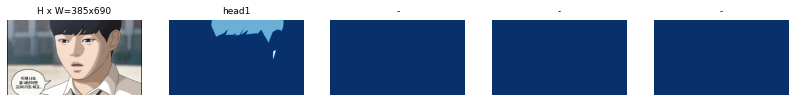

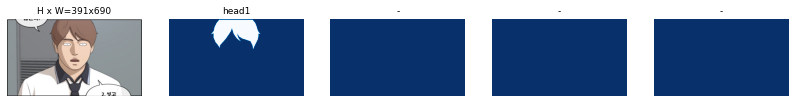

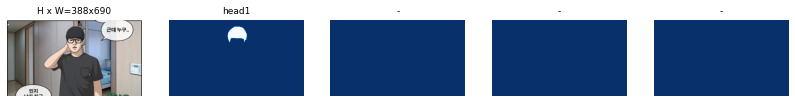

Displaying examples from validation dataset:


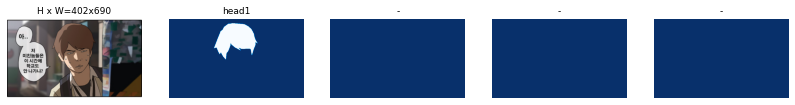

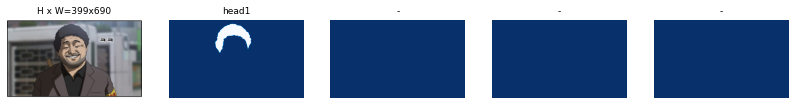

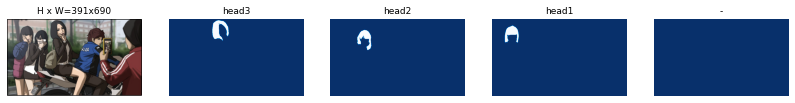

In [ ]:
for name, dataset in [('training', dataset_train), ('validation', dataset_val)]:
    print(f'Displaying examples from {name} dataset:')
    
    image_ids = np.random.choice(dataset.image_ids, 3)
    for image_id in image_ids:
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Create the Training Model and Train
This code is largely borrowed from the train_shapes.ipynb notebook in the Matterport repo.

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training
Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers='all' to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=200, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ../matterport_mask_rcnn/logs/cocosynth_dataset20210108T2021/mask_rcnn_cocosynth_dataset_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Tim

/home/marcomx/anaconda3/envs/mrcnn/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marcomx/anaconda3/envs/mrcnn/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marcomx/anaconda3/envs/mrcnn/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/home/marcomx/anaconda3/envs/mrcnn/lib/python3.6/site-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/200
 9/10 [==========================>...] - ETA: 2s - loss: 4.7195 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 1.1867 - mrcnn_class_loss: 1.3185 - mrcnn_bbox_loss: 1.2368 - mrcnn_mask_loss: 0.9470

/home/marcomx/anaconda3/envs/mrcnn/lib/python3.6/site-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



10/10 [==============================] - 42s 4s/step - loss: 4.4288 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 1.2417 - mrcnn_class_loss: 1.1866 - mrcnn_bbox_loss: 1.1131 - mrcnn_mask_loss: 0.8523 - val_loss: 2.4838 - val_rpn_class_loss: 0.0190 - val_rpn_bbox_loss: 0.9245 - val_mrcnn_class_loss: 0.1483 - val_mrcnn_bbox_loss: 0.5880 - val_mrcnn_mask_loss: 0.8040
Epoch 2/200
10/10 [==============================] - 25s 2s/step - loss: 3.1769 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 1.3246 - mrcnn_class_loss: 0.1631 - mrcnn_bbox_loss: 1.0561 - mrcnn_mask_loss: 0.5971 - val_loss: 2.5273 - val_rpn_class_loss: 0.0187 - val_rpn_bbox_loss: 0.7470 - val_mrcnn_class_loss: 0.4691 - val_mrcnn_bbox_loss: 0.7832 - val_mrcnn_mask_loss: 0.5093
Epoch 3/200
10/10 [==============================] - 25s 2s/step - loss: 2.2302 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 1.3351 - mrcnn_class_loss: 0.1320 - mrcnn_bbox_loss: 0.3598 - mrcnn_mask_loss: 0.3575 - val_loss: 2.9329 - val_rpn_class_loss: 0.0357 - val

Epoch 44/200
10/10 [==============================] - 25s 2s/step - loss: 1.7059 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.8985 - mrcnn_class_loss: 0.2954 - mrcnn_bbox_loss: 0.3006 - mrcnn_mask_loss: 0.1918 - val_loss: 1.4500 - val_rpn_class_loss: 0.0182 - val_rpn_bbox_loss: 0.5254 - val_mrcnn_class_loss: 0.2274 - val_mrcnn_bbox_loss: 0.4504 - val_mrcnn_mask_loss: 0.2286
Epoch 45/200
10/10 [==============================] - 25s 2s/step - loss: 1.3519 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.7019 - mrcnn_class_loss: 0.1862 - mrcnn_bbox_loss: 0.2582 - mrcnn_mask_loss: 0.1850 - val_loss: 1.3301 - val_rpn_class_loss: 0.0160 - val_rpn_bbox_loss: 0.5667 - val_mrcnn_class_loss: 0.2295 - val_mrcnn_bbox_loss: 0.3362 - val_mrcnn_mask_loss: 0.1817
Epoch 46/200
10/10 [==============================] - 25s 2s/step - loss: 1.4392 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.5549 - mrcnn_class_loss: 0.2953 - mrcnn_bbox_loss: 0.3128 - mrcnn_mask_loss: 0.2649 - val_loss: 1.2506 - val_rpn_class_loss

Epoch 66/200
10/10 [==============================] - 25s 2s/step - loss: 1.1311 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5508 - mrcnn_class_loss: 0.1588 - mrcnn_bbox_loss: 0.2125 - mrcnn_mask_loss: 0.1881 - val_loss: 1.3848 - val_rpn_class_loss: 0.0161 - val_rpn_bbox_loss: 0.6866 - val_mrcnn_class_loss: 0.1068 - val_mrcnn_bbox_loss: 0.3847 - val_mrcnn_mask_loss: 0.1906
Epoch 67/200
10/10 [==============================] - 25s 2s/step - loss: 1.1566 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5135 - mrcnn_class_loss: 0.2551 - mrcnn_bbox_loss: 0.2259 - mrcnn_mask_loss: 0.1419 - val_loss: 0.9656 - val_rpn_class_loss: 0.0080 - val_rpn_bbox_loss: 0.3657 - val_mrcnn_class_loss: 0.1743 - val_mrcnn_bbox_loss: 0.2824 - val_mrcnn_mask_loss: 0.1352
Epoch 68/200
10/10 [==============================] - 25s 2s/step - loss: 1.1329 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4681 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.2448 - mrcnn_mask_loss: 0.1872 - val_loss: 0.9703 - val_rpn_class_loss

Epoch 88/200
10/10 [==============================] - 25s 2s/step - loss: 1.0797 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4124 - mrcnn_class_loss: 0.2906 - mrcnn_bbox_loss: 0.1983 - mrcnn_mask_loss: 0.1654 - val_loss: 1.5390 - val_rpn_class_loss: 0.0068 - val_rpn_bbox_loss: 0.5919 - val_mrcnn_class_loss: 0.2748 - val_mrcnn_bbox_loss: 0.4588 - val_mrcnn_mask_loss: 0.2067
Epoch 89/200
10/10 [==============================] - 25s 2s/step - loss: 0.8113 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2648 - mrcnn_class_loss: 0.1932 - mrcnn_bbox_loss: 0.1642 - mrcnn_mask_loss: 0.1767 - val_loss: 1.5164 - val_rpn_class_loss: 0.0128 - val_rpn_bbox_loss: 0.5803 - val_mrcnn_class_loss: 0.3144 - val_mrcnn_bbox_loss: 0.3862 - val_mrcnn_mask_loss: 0.2227
Epoch 90/200
10/10 [==============================] - 25s 2s/step - loss: 0.8971 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.3876 - mrcnn_class_loss: 0.2455 - mrcnn_bbox_loss: 0.1382 - mrcnn_mask_loss: 0.1164 - val_loss: 1.1744 - val_rpn_class_loss

Epoch 110/200
10/10 [==============================] - 25s 2s/step - loss: 0.9040 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.3558 - mrcnn_class_loss: 0.2059 - mrcnn_bbox_loss: 0.1766 - mrcnn_mask_loss: 0.1459 - val_loss: 1.5682 - val_rpn_class_loss: 0.0164 - val_rpn_bbox_loss: 0.6195 - val_mrcnn_class_loss: 0.3795 - val_mrcnn_bbox_loss: 0.3425 - val_mrcnn_mask_loss: 0.2102
Epoch 111/200
10/10 [==============================] - 25s 2s/step - loss: 0.9668 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.3652 - mrcnn_class_loss: 0.2113 - mrcnn_bbox_loss: 0.1765 - mrcnn_mask_loss: 0.1960 - val_loss: 1.7375 - val_rpn_class_loss: 0.0174 - val_rpn_bbox_loss: 0.7348 - val_mrcnn_class_loss: 0.3347 - val_mrcnn_bbox_loss: 0.3276 - val_mrcnn_mask_loss: 0.3229
Epoch 112/200
10/10 [==============================] - 25s 2s/step - loss: 0.6869 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2729 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.1403 - val_loss: 1.7501 - val_rpn_class_l

Epoch 132/200
10/10 [==============================] - 25s 2s/step - loss: 0.5845 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1751 - mrcnn_class_loss: 0.1662 - mrcnn_bbox_loss: 0.1165 - mrcnn_mask_loss: 0.1193 - val_loss: 0.9623 - val_rpn_class_loss: 0.0055 - val_rpn_bbox_loss: 0.2661 - val_mrcnn_class_loss: 0.1394 - val_mrcnn_bbox_loss: 0.3289 - val_mrcnn_mask_loss: 0.2224
Epoch 133/200
10/10 [==============================] - 25s 2s/step - loss: 0.6788 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2795 - mrcnn_class_loss: 0.1203 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.1295 - val_loss: 1.6720 - val_rpn_class_loss: 0.0116 - val_rpn_bbox_loss: 0.6983 - val_mrcnn_class_loss: 0.4452 - val_mrcnn_bbox_loss: 0.3007 - val_mrcnn_mask_loss: 0.2161
Epoch 134/200
10/10 [==============================] - 25s 2s/step - loss: 0.8284 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4364 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1276 - val_loss: 1.5070 - val_rpn_class_l

Epoch 154/200
10/10 [==============================] - 25s 3s/step - loss: 0.7454 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.2677 - mrcnn_class_loss: 0.2357 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.1241 - val_loss: 1.7887 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.5300 - val_mrcnn_class_loss: 0.5987 - val_mrcnn_bbox_loss: 0.4224 - val_mrcnn_mask_loss: 0.2280
Epoch 155/200
10/10 [==============================] - 25s 3s/step - loss: 0.6751 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1883 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.1298 - val_loss: 1.2112 - val_rpn_class_loss: 0.0138 - val_rpn_bbox_loss: 0.4768 - val_mrcnn_class_loss: 0.3159 - val_mrcnn_bbox_loss: 0.2754 - val_mrcnn_mask_loss: 0.1293
Epoch 156/200
10/10 [==============================] - 25s 2s/step - loss: 1.0680 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.4168 - mrcnn_class_loss: 0.3070 - mrcnn_bbox_loss: 0.1755 - mrcnn_mask_loss: 0.1426 - val_loss: 1.4580 - val_rpn_class_l

Epoch 176/200
10/10 [==============================] - 25s 2s/step - loss: 0.6553 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.1977 - mrcnn_bbox_loss: 0.1530 - mrcnn_mask_loss: 0.1538 - val_loss: 1.5013 - val_rpn_class_loss: 0.0104 - val_rpn_bbox_loss: 0.6047 - val_mrcnn_class_loss: 0.3370 - val_mrcnn_bbox_loss: 0.3845 - val_mrcnn_mask_loss: 0.1648
Epoch 177/200
10/10 [==============================] - 25s 2s/step - loss: 0.8088 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2691 - mrcnn_class_loss: 0.2134 - mrcnn_bbox_loss: 0.1777 - mrcnn_mask_loss: 0.1383 - val_loss: 1.7461 - val_rpn_class_loss: 0.0166 - val_rpn_bbox_loss: 0.6688 - val_mrcnn_class_loss: 0.5827 - val_mrcnn_bbox_loss: 0.3102 - val_mrcnn_mask_loss: 0.1678
Epoch 178/200
10/10 [==============================] - 25s 2s/step - loss: 0.4868 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.1107 - val_loss: 1.7349 - val_rpn_class_l

Epoch 198/200
10/10 [==============================] - 25s 2s/step - loss: 0.6979 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.2824 - mrcnn_class_loss: 0.1782 - mrcnn_bbox_loss: 0.0997 - mrcnn_mask_loss: 0.1241 - val_loss: 1.5454 - val_rpn_class_loss: 0.0057 - val_rpn_bbox_loss: 0.6326 - val_mrcnn_class_loss: 0.2214 - val_mrcnn_bbox_loss: 0.3858 - val_mrcnn_mask_loss: 0.2999
Epoch 199/200
10/10 [==============================] - 25s 2s/step - loss: 0.5692 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2277 - mrcnn_class_loss: 0.1182 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1206 - val_loss: 1.4531 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.6263 - val_mrcnn_class_loss: 0.2090 - val_mrcnn_bbox_loss: 0.3578 - val_mrcnn_mask_loss: 0.2498
Epoch 200/200
10/10 [==============================] - 25s 3s/step - loss: 0.5569 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1398 - mrcnn_class_loss: 0.2096 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1089 - val_loss: 1.8230 - val_rpn_class_l

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=250, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 200. LR=0.0001

Checkpoint Path: ../matterport_mask_rcnn/logs/cocosynth_dataset20210108T2021/mask_rcnn_cocosynth_dataset_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b 

/home/marcomx/anaconda3/envs/mrcnn/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marcomx/anaconda3/envs/mrcnn/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marcomx/anaconda3/envs/mrcnn/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marcomx/anaconda3/envs/mrcnn/lib/python3.6/sit

Epoch 201/250
 9/10 [==========================>...] - ETA: 3s - loss: 0.6030 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1526 - mrcnn_class_loss: 0.1581 - mrcnn_bbox_loss: 0.1333 - mrcnn_mask_loss: 0.1471

/home/marcomx/anaconda3/envs/mrcnn/lib/python3.6/site-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


10/10 [==============================] - 38s 4s/step - loss: 0.6071 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.1467 - mrcnn_class_loss: 0.1692 - mrcnn_bbox_loss: 0.1371 - mrcnn_mask_loss: 0.1425 - val_loss: 2.4083 - val_rpn_class_loss: 0.0118 - val_rpn_bbox_loss: 0.7858 - val_mrcnn_class_loss: 0.7889 - val_mrcnn_bbox_loss: 0.3554 - val_mrcnn_mask_loss: 0.4663
Epoch 202/250
10/10 [==============================] - 31s 3s/step - loss: 0.5478 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1662 - mrcnn_class_loss: 0.1229 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.1158 - val_loss: 1.1458 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.3607 - val_mrcnn_class_loss: 0.2641 - val_mrcnn_bbox_loss: 0.2690 - val_mrcnn_mask_loss: 0.2403
Epoch 203/250
10/10 [==============================] - 31s 3s/step - loss: 0.7644 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.3134 - mrcnn_class_loss: 0.1857 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.1429 - val_loss: 1.5918 - val_rpn_class_loss: 0.0076 - 

Epoch 223/250
10/10 [==============================] - 31s 3s/step - loss: 0.6228 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.3289 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1172 - val_loss: 1.1570 - val_rpn_class_loss: 0.0110 - val_rpn_bbox_loss: 0.4218 - val_mrcnn_class_loss: 0.3770 - val_mrcnn_bbox_loss: 0.1924 - val_mrcnn_mask_loss: 0.1547
Epoch 224/250
10/10 [==============================] - 31s 3s/step - loss: 0.5251 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.1692 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1322 - val_loss: 1.5618 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 0.6601 - val_mrcnn_class_loss: 0.4720 - val_mrcnn_bbox_loss: 0.2469 - val_mrcnn_mask_loss: 0.1757
Epoch 225/250
10/10 [==============================] - 31s 3s/step - loss: 0.2878 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0444 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.1236 - val_loss: 2.0811 - val_rpn_class_l

Epoch 245/250
10/10 [==============================] - 31s 3s/step - loss: 0.2731 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.0383 - mrcnn_mask_loss: 0.1136 - val_loss: 1.9729 - val_rpn_class_loss: 0.0153 - val_rpn_bbox_loss: 0.7066 - val_mrcnn_class_loss: 0.7387 - val_mrcnn_bbox_loss: 0.3123 - val_mrcnn_mask_loss: 0.2000
Epoch 246/250
10/10 [==============================] - 31s 3s/step - loss: 0.3642 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1045 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1116 - val_loss: 1.1469 - val_rpn_class_loss: 0.0120 - val_rpn_bbox_loss: 0.2647 - val_mrcnn_class_loss: 0.3755 - val_mrcnn_bbox_loss: 0.3444 - val_mrcnn_mask_loss: 0.1503
Epoch 247/250
10/10 [==============================] - 31s 3s/step - loss: 0.3650 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1033 - val_loss: 1.2234 - val_rpn_class_l

# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

In [ ]:
class InferenceConfig(CocoSynthConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [ ]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)



Instructions for updating:
Use `tf.cast` instead.


### Load Trained Weights
Note: The code is set to find_last() by default, but you can also point the model to a specific pretrained weights file if you use line 3 instead of line 4.

In [ ]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = str(Path(ROOT_DIR) / "logs" / "box_synthetic20190328T2255/mask_rcnn_box_synthetic_0016.h5" )
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../matterport_mask_rcnn/logs/cocosynth_dataset20210108T2021/mask_rcnn_cocosynth_dataset_0250.h5
Re-starting from epoch 250


# Image Inference
Run model.detect() on real images.

We get some false positives, and some misses. More training images are likely needed to improve the results.

You can adjust the "figsize" in the cell below to make the image larger or smaller.

Processing 1 images
image                    shape: (429, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



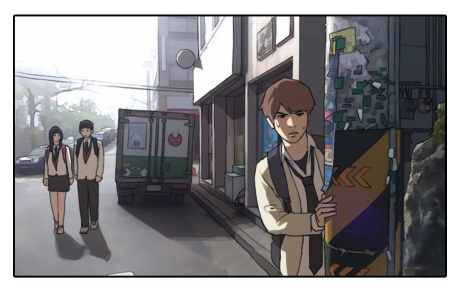

Processing 1 images
image                    shape: (394, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


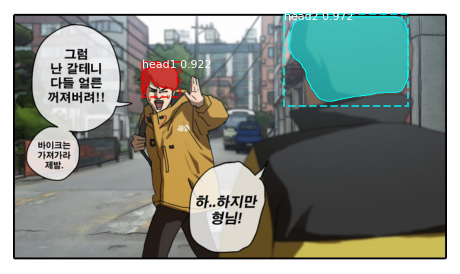

Processing 1 images
image                    shape: (402, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


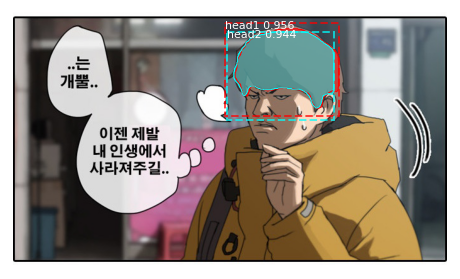

Processing 1 images
image                    shape: (391, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


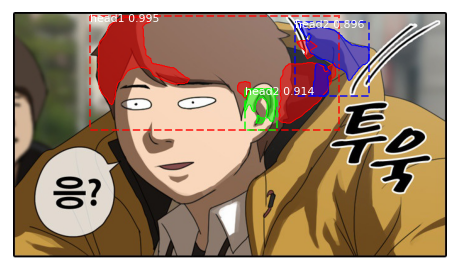

Processing 1 images
image                    shape: (399, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


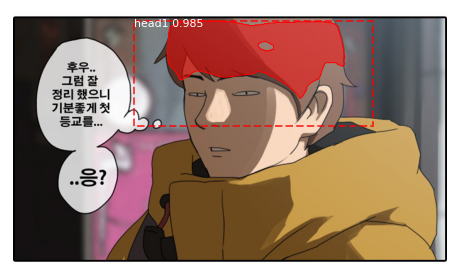

Processing 1 images
image                    shape: (399, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


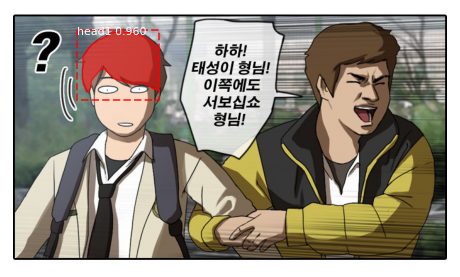

Processing 1 images
image                    shape: (399, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


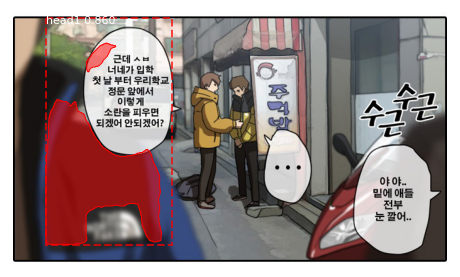

Processing 1 images
image                    shape: (519, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


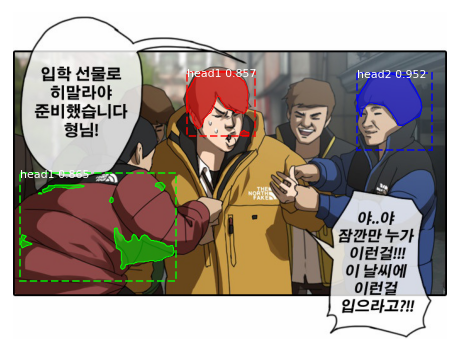

Processing 1 images
image                    shape: (391, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



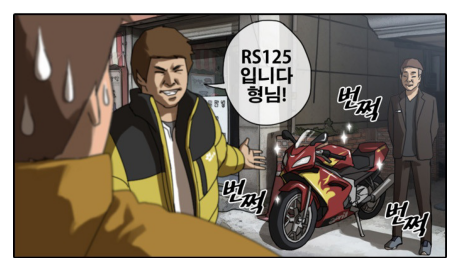

Processing 1 images
image                    shape: (431, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


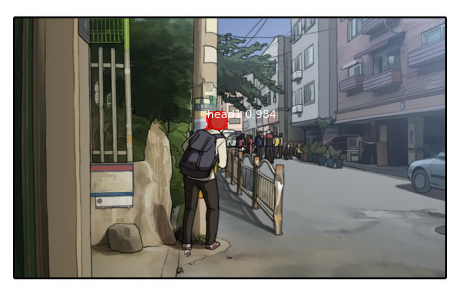

Processing 1 images
image                    shape: (567, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


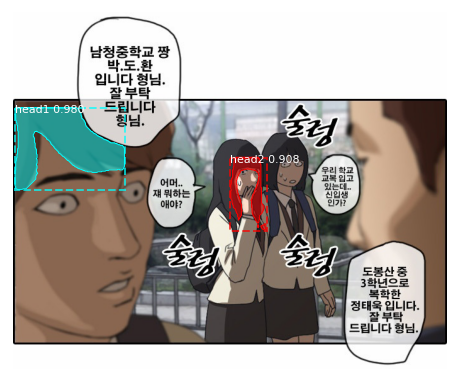

Processing 1 images
image                    shape: (394, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


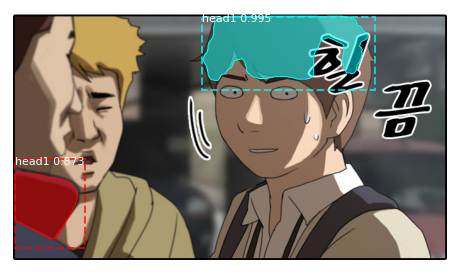

Processing 1 images
image                    shape: (399, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


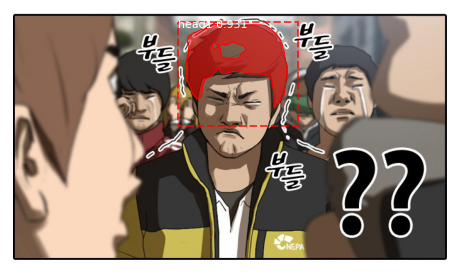

Processing 1 images
image                    shape: (402, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


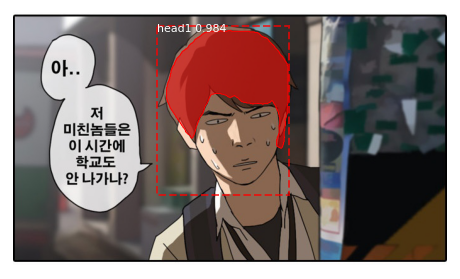

Processing 1 images
image                    shape: (423, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


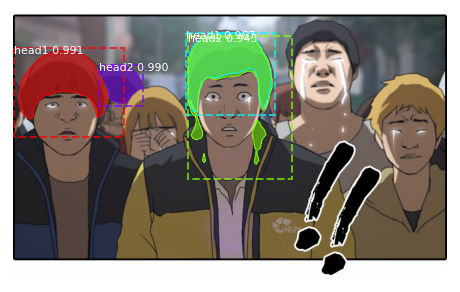

Processing 1 images
image                    shape: (406, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


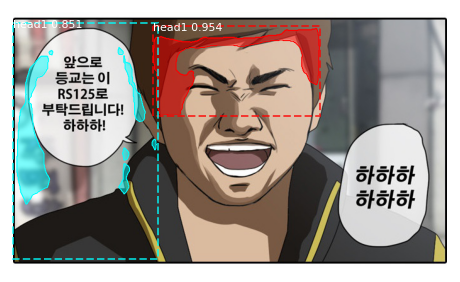

Processing 1 images
image                    shape: (402, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


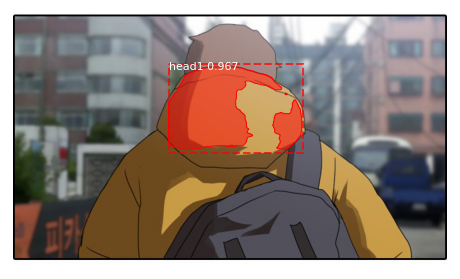

Processing 1 images
image                    shape: (825, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  825.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


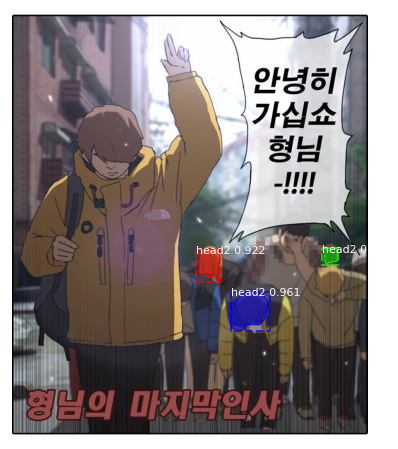

Processing 1 images
image                    shape: (401, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


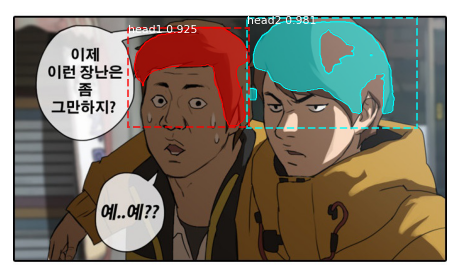

Processing 1 images
image                    shape: (585, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


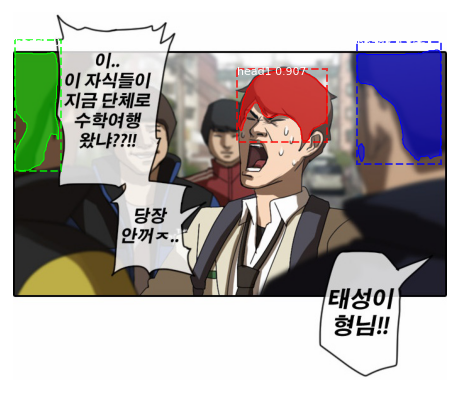

Processing 1 images
image                    shape: (399, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


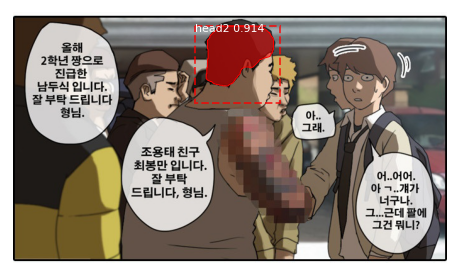

Processing 1 images
image                    shape: (399, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


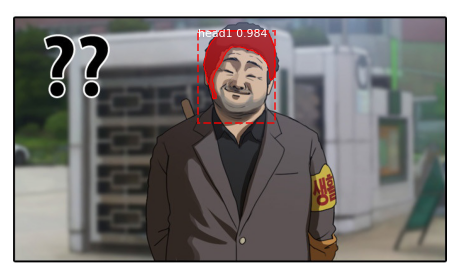

Processing 1 images
image                    shape: (391, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


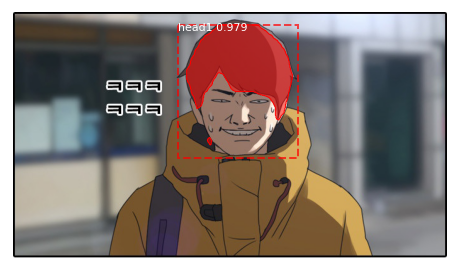

Processing 1 images
image                    shape: (399, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


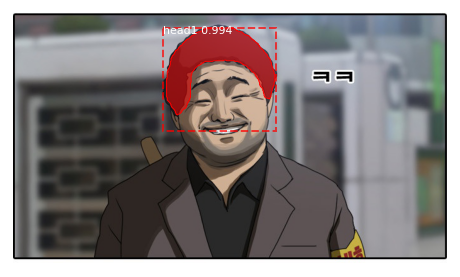

Processing 1 images
image                    shape: (471, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


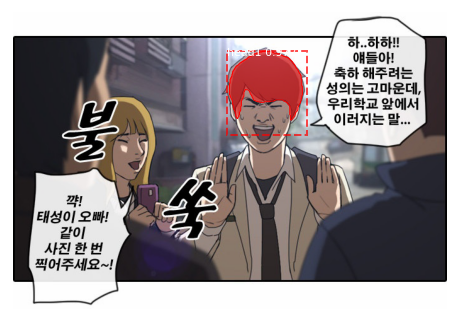

Processing 1 images
image                    shape: (399, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


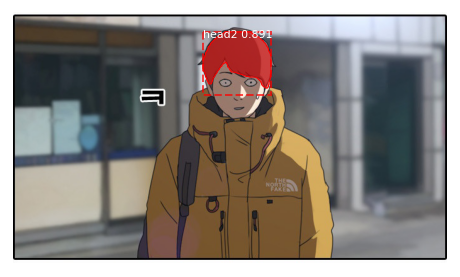

Processing 1 images
image                    shape: (391, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


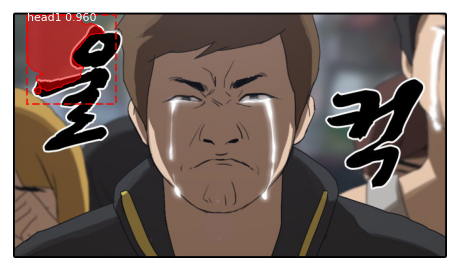

Processing 1 images
image                    shape: (391, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


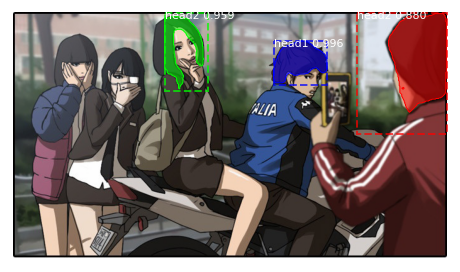

Processing 1 images
image                    shape: (399, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


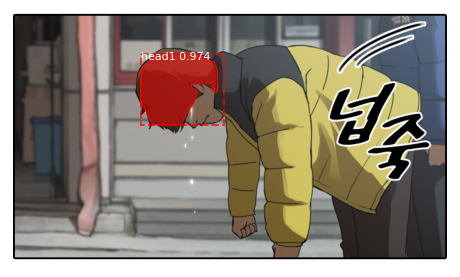

Processing 1 images
image                    shape: (391, 690, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  690.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


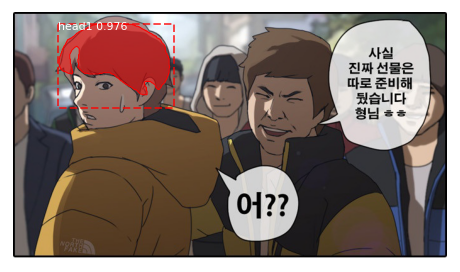